# CAMELS Multifield Dataset Generative Model

Implemets U-net architecture to predict astrophysical maps from an input map in another astrophysical field. Using U-net due to some expected deterministic relationships between fields.

## 1. Data Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm  # plotting on log scale

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation
from keras import layers, models

# import sklean
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
class Map:
    '''Takes label and image file names, opens and processes the data ready to
    implement into an model. Provides frequency plotting methods.'''

    path = "/content/drive/MyDrive/Colab_Notebooks/Camel_Project/Camels/"

    def __init__(self, labelfile: str, imagefile: str) -> None:
        self.labelfile = labelfile
        self.imagefile = imagefile

        # load files
        try:
            self.params = np.loadtxt(Map.path+self.labelfile)
            self.img_map = np.load(Map.path+self.imagefile)
        except Exception as e:
            print(f'Error loading files: {e}')
            self.params = None
            self.img_map = None

        # Useful Variables
        # images per parameter line
        if self.img_map is not None:
            self.img_per_param_line = self.img_map.shape[0] // self.params.shape[0]
        # range of values varied in the dataset
        if self.params is not None:
            self.p_range = self.params.shape[0] // self.params.shape[1]

    def info(self) -> None:
        '''Provides some basic information about the 2DMap provided'''
        print("params.shape",self.params.shape)
        print("img_map.shape",self.img_map.shape)
        print("Maps/Images per paramater line",self.img_map.shape[0]//self.params.shape[0])
        print("Maximum Value",np.max(self.img_map[0]))
        print("Minimum Value",np.min(self.img_map[0]))
        fig, ax = plt.subplots()
        ax.imshow(np.log10(self.img_map[0]),cmap="binary")
        ax.set_title("First image")

    def log_scale(self) -> None:
        '''Log scales and then noramlizes values ~{0,1} on per image basis to deal with
        large intensity distribution.
        NOTE: After experimenting this produced highest contrast and best utilization of range'''
        # loop over every image
        for i, image in enumerate(self.img_map):
            self.img_map[i] = np.log10(self.img_map[i]) # log scale
            self.img_map[i] = self.img_map[i] / np.min(self.img_map[i]) # normalize

        print("Total max",np.max(self.img_map))
        print("Total mean",np.mean(self.img_map))
        print("Total std",np.std(self.img_map))
        print("Total min",np.min(self.img_map),"\n")

    def resize(self, verbose=True) -> np.ndarray:
        '''Resized the label array to fit images per parameter line'''
        # resize labels to match images
        resized_labels = np.zeros((self.img_map.shape[0], self.params.shape[1]))
        count = 0
        for row in self.params:
            for i in range(self.img_per_param_line):
                resized_labels[count] = row
                count += 1
        # check
        for index, row in enumerate(self.params):
            if np.array_equal(resized_labels[index*self.img_per_param_line], row):
                continue
            else:
                print("ERROR : rows not equal")
                print(resized_labels[index*self.img_per_param_line], row)

        if verbose:
            print(f"resized_labels.shape : {resized_labels.shape} \n")

        return resized_labels

    def extract_param(self, p: int, labels: np.ndarray, verbose=True) -> np.ndarray:
        '''Returns a modified array that selects a specific parameter from the label file.
        Also appropriately modifies the images array to match.
        NOTE: Parameters must be indexed from zero.'''

        # extract labels
        new_labels = labels[(p*self.p_range*self.img_per_param_line) : ((p+1)*self.p_range*self.img_per_param_line) : 1 , p:p+1]

        # modified images array
        images = self.img_map[(p*self.p_range*self.img_per_param_line) : ((p+1)*self.p_range*self.img_per_param_line) : 1]

        if verbose:
            print(f"labels.shape : {new_labels.shape}")
            print(f"images.shape : {images.shape}")
            print(f"p_range : {self.p_range} \n")

        return new_labels, images

    def split_data(self, labels: np.ndarray, images: np.ndarray) -> np.ndarray:
        '''Uses sklearn shuffle to mix up the labels and images in the same way - then performs an 80-10-10 split'''

        labels_shuffled, images_shuffled = shuffle(labels, images) # shuffle before we split

        # split into test and train
        X_train, X_test, y_train, y_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.10, random_state=42)
        # split train further into validation and train
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

        # print shapes of model input data
        print(f"X_train.shape :  {X_train.shape}")
        print(f"X_test.shape :  {X_test.shape}")
        print(f"X_val.shape: {X_val.shape}")
        print(f"y_train.shape : {y_train.shape}")
        print(f"y_test.shape : {y_test.shape}")
        print(f"y_val.shape : {y_val.shape} \n")

        return X_train, X_test, X_val, y_train, y_test, y_val

    def plot_hist(self, labels: np.ndarray) -> None:
        '''Plots a histogram to see if the distribution of parameter values is uniform
        (important to prevent overfitting).'''

        parameter = labels[:, 0]
        # plot histogram
        fig, ax = plt.subplots()
        ax.hist(parameter[0:self.p_range*self.img_per_param_line:1], bins=self.p_range)
        # formatting
        ax.set_title('Frequency plot of select parameter')
        ax.set_xlabel('Parameter')
        ax.set_ylabel('Frequency')

Total max 1.0
Total mean 0.8338388
Total std 0.1358352
Total min 0.31428388 

Total max 2.2699435
Total mean 1.2789434
Total std 0.2303845
Total min 1.0 

Total max 1.0
Total mean 0.8639783
Total std 0.067270614
Total min 0.35784784 

params.shape (66, 6)
img_map.shape (990, 256, 256)
Maps/Images per paramater line 15
Maximum Value 1.0
Minimum Value 0.38641185
params.shape (66, 6)
img_map.shape (990, 256, 256)
Maps/Images per paramater line 15
Maximum Value 1.7838976
Minimum Value 1.0
params.shape (66, 6)
img_map.shape (990, 256, 256)
Maps/Images per paramater line 15
Maximum Value 1.0
Minimum Value 0.5563246


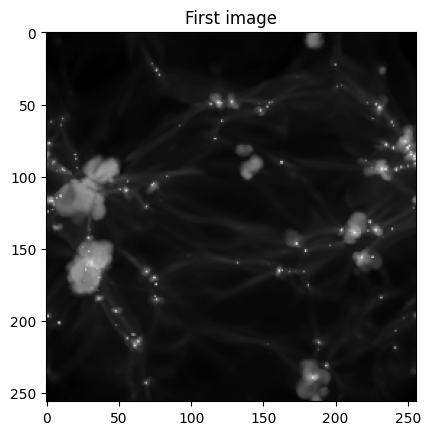

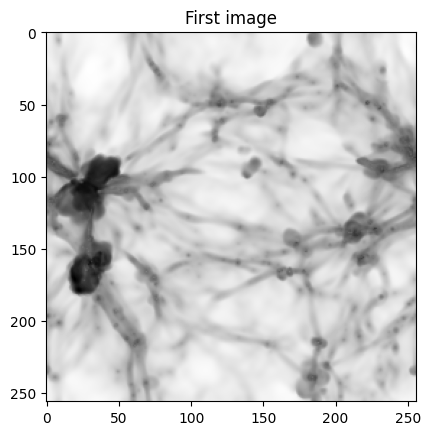

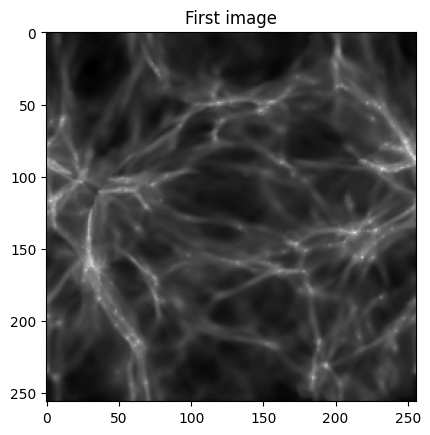

In [4]:
labelFile='params_1P_IllustrisTNG.txt'
firstFile='Maps_B_IllustrisTNG_1P_z=0.00.npy'
secondFile='Maps_T_IllustrisTNG_1P_z=0.00.npy'
thirdFile='Maps_ne_IllustrisTNG_1P_z=0.00.npy'

# Instantiate map objects
bMap = Map(labelFile,firstFile) # magnetic field
tMap = Map(labelFile,secondFile) # temperature distribution field
eMap = Map(labelFile,thirdFile) # electron density field
# Log and normalize images
bMap.log_scale()
tMap.log_scale()
eMap.log_scale()
# Display some basic info
bMap.info()
tMap.info()
eMap.info()

## 2. Build U-Net Model

In [5]:
def conv_block(input, num_filters):
    '''Defines and returns convolutional block for encoder and decoder blocks'''

    x = layers.Conv2D(num_filters, 3, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(input, num_filters):
    '''Defines and returns an encoder block providing outputs before and after max pooling'''

    x = conv_block(input, num_filters) # output before maxpool for skip features
    p = layers.MaxPool2D((2,2))(x) # output after maxpool for next layer input

    return x, p

def decoder_block(input, skip_features, num_filters):
    '''Defines and returns an decoder block providing outputs before and after up sampling'''

    x = layers.Conv2DTranspose(num_filters, 3, strides=(2,2), padding='same')(input) # upsample and learn features
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def u_net(input_shape):
    '''Builds U-net architecture using encoder and decoder blocks. Returns a keras model.'''
    input = keras.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(input, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    bridge = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bridge, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    output = layers.Conv2D(1, 1, activation='linear')(d4)

    model = keras.Model(inputs=input, outputs=output, name='U-Net')

    return model

## 3. Train Model to Predict Temperature Field

In [6]:
def eval_test(model, X_test, y_test, history):
    '''Evaluate model using test images and plot MAE graph. Returns test loss and mae.'''

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'MAE Loss - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

    # Plotting the training MAE compared to the validation MAE
    plt.plot(history.history['mae'], label='MAE')
    plt.plot(history.history['val_mae'], label = 'Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.legend(loc='best')
    plt.title('Model performance')
    plt.ylim(0,0.5)

    return test_loss, test_mae

In [9]:
# Load image data
t_images = tMap.img_map
b_images = bMap.img_map
e_images = eMap.img_map
# Predicting temperature field from magnetic field
X_train, X_test, X_val, y_train, y_test, y_val = bMap.split_data(t_images, b_images)

X_train.shape :  (792, 256, 256)
X_test.shape :  (99, 256, 256)
X_val.shape: (99, 256, 256)
y_train.shape : (792, 256, 256)
y_test.shape : (99, 256, 256)
y_val.shape : (99, 256, 256) 



In [13]:
input_shape = (X_train.shape[1], X_train.shape[2], 1) # greyscale images
model = u_net(input_shape)
model.compile(optimizer='adam', loss='huber', metrics=['mae'])

In [14]:
# Checkpoint saving
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=Map.path+'unet_checkpoint.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [15]:
# Train
T_history = model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[checkpoints, early_stopping], validation_data=(X_val, y_val))
T_predictions = model.predict(X_test)

# Save data
np.save(Map.path+'/predict_T_history.npy', T_history)
np.save(Map.path+'/predictions_T.npy', T_predictions)
model.save(Map.path+'unet_predict_T.keras')

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1695 - mae: 0.3813   
Epoch 1: val_loss improved from inf to 0.37590, saving model to /content/drive/MyDrive/Colab_Notebooks/Camel_Project/Camels/unet_checkpoint.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.1672 - mae: 0.3774 - val_loss: 0.3759 - val_mae: 0.8360
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - loss: 0.0047 - mae: 0.0709
Epoch 2: val_loss improved from 0.37590 to 0.15739, saving model to /content/drive/MyDrive/Colab_Notebooks/Camel_Project/Camels/unet_checkpoint.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 957ms/step - loss: 0.0048 - mae: 0.0709 - val_loss: 0.1574 - val_mae: 0.5081
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - loss: 0.0044 - mae: 0.0708
Epoch 3: val_loss improved from 0.15739 to 0.07395, saving model to /content/drive/MyDrive/Colab_Notebooks/Camel_Project/Camels/unet_checkpoint.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 925ms/step - loss: 0.0044 - mae: 0.0707 - val_loss: 0.0739 - val_m

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - loss: 9.1399e-04 - mae: 0.0289
MAE Loss - Test Loss: 0.0009220566716976464, Test MAE: 0.028991935774683952



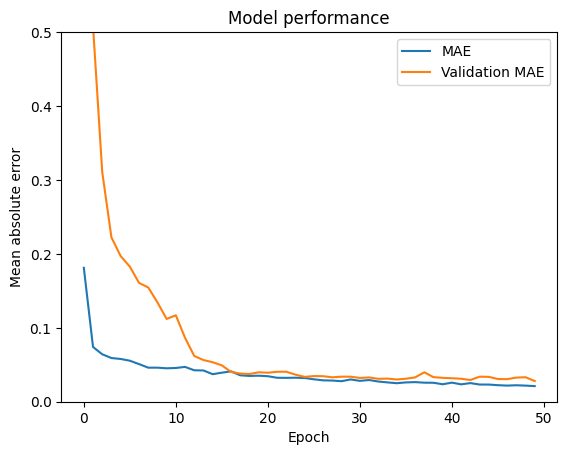

In [16]:
T_loss, T_mae = eval_test(model, X_test, y_test, T_history)

Text(0.5, 1.0, 'Real Temperature Image image')

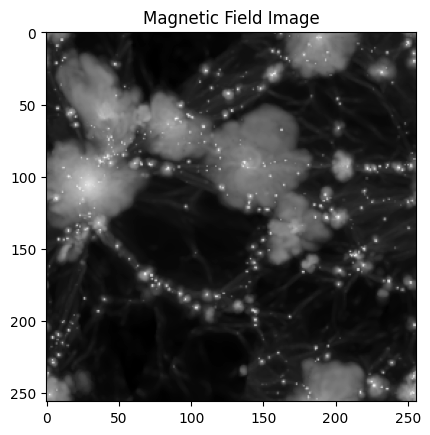

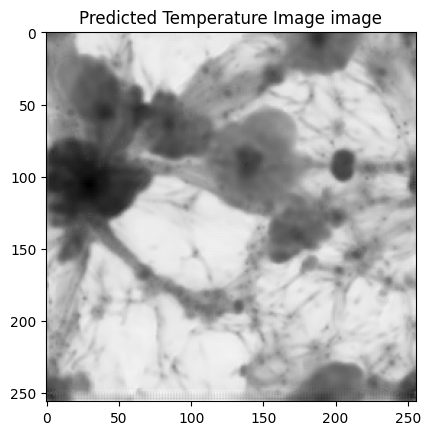

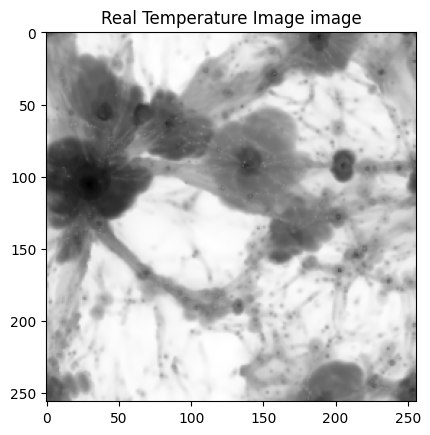

In [18]:
fig, ax = plt.subplots()
ax.imshow(np.log10(X_test[0]),cmap="binary")
ax.set_title("Magnetic Field Image")

fig, ax = plt.subplots()
ax.imshow(np.log10(T_predictions[0]),cmap="binary")
ax.set_title("Predicted Temperature Image image")

fig, ax = plt.subplots()
ax.imshow(np.log10(y_test[0]),cmap="binary")
ax.set_title("Real Temperature Image image")

## 4. Predicting Electron Density

This is more interesting as electron density field is less similar to the magnetic field.